En esta parte del proyecto vamos a cargar los pesos calculados anteriormente en el modelo y vamos a predecir las imágenes con las construcciones y guardarlas para su posterior comparación con las imágenes segmentadas originales.

En este entorno he llegado a trabajar con imágenes de resolución (4000,4000) equivalente a un kilómetro cuadrado.

Las imágenes que le vamos a pasar tienen una resolución de (1024,1024) que equivale a 256*256 metros, he elegido este tamaño porque visualmente es más cómodo para la visualización de los cambios, con imágenes más grande se veía el resultado final demassiado pequeño.

In [1]:
#Informacion sobre la GPU del entorno
#Codigo proporcionado en documentacion Google Colab

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed May 20 09:53:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    39W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#Informacion sobre memoria disponible
#Codigo proporcionado en documentacion Google Colab

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
#instalamos la libreria segmentation-models
!pip install segmentation-models==1.0.0

In [4]:
%matplotlib inline

import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from PIL import Image

from segmentation_models import Unet
from segmentation_models.metrics import iou_score
from segmentation_models.metrics import IOUScore
from segmentation_models.losses import JaccardLoss
from google.colab import drive



Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [5]:
#Montamos nuestro entorno del drive para tener acceso a los ficheros
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Creamos el modelo 
modelo = Unet(
    #VGG19
    backbone_name = 'vgg19',
    #Clases=1 , las etiquetas son binarias
    classes = 1,
    #Activacion sigmoid para segmentacion binaria
    activation = 'sigmoid',
    #cargamos los pesos de imagenet
    encoder_weights = 'imagenet')

#cargamos los pesos en el modelo
modelo.load_weights('/content/drive/My Drive/Colab Notebooks/vgg19_2_200_iou.h5')

In [0]:
#path de lass imagenes 
path_test_im = '/content/drive/My Drive/Colab Notebooks/dataset/aerial/pre_tiles/tile_im/'

In [8]:
from keras.preprocessing.image import ImageDataGenerator

#Normalizamos las imagenes
test_datagen = ImageDataGenerator(rescale=1./255)

img_test = test_datagen.flow_from_directory(
  #path de las imagenes validacion RGB
  path_test_im,
  #resolucion de lass imagenes
  target_size = (1024, 1024,),
  #Determina el tipo de matrices de etiquetas que se devuelven,con None devuelve solo la imagen
  class_mode = None,
  #Obtenemos los datos en orden alfanumerico
  shuffle = False
)

Found 4 images belonging to 1 classes.


In [0]:
#predecimos el conjunto de imagenes para la validacion, se obtiene una probabilidad entr 0 y 1 para casa pixel de ser construccion
prob_test = modelo.predict_generator(img_test)

In [0]:
#creamos un array de ceros con las dimensiones de la prediccion
y_test = np.zeros(prob_test.shape)
#Los valores de preccion mayor que 0.5 los consideramos construccion y les asignamos mascara 255
#este valor se puede cambiar si queremos aumentar o disminuir la probabilidad para ser construccion
y_test[prob_test > 0.50] = 255


Text(0.5, 1.0, 'Mascara predicha')

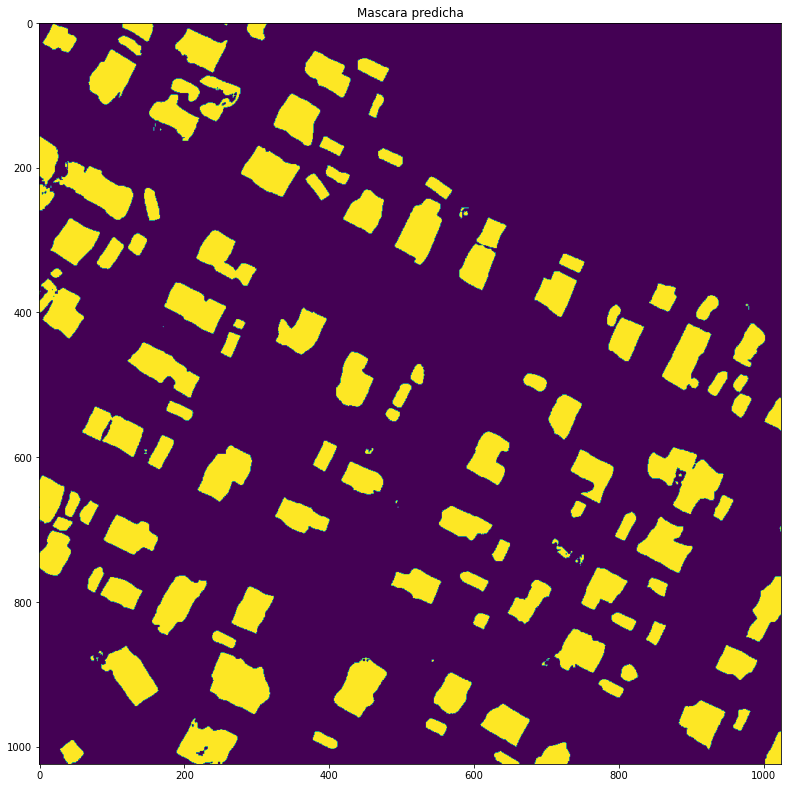

In [11]:
#Mostramos un ejemplo
plt.figure(figsize = (30, 30))
plt.subplot(224)
plt.imshow(y_test[0,:,:,0])
plt.title('Mascara predicha')

In [12]:
#Listamos las imagenes del directorio
ficheros = !ls '/content/drive/My Drive/Colab Notebooks/dataset/aerial/pre_tiles/tile_im/tile_im/'

#guardamos las imagenes predichas con formato PRE_Nombre.tif
for f in range(0, len(ficheros)):
  #guardamos en im los valores del array
  im = (y_test[f,:,:,0]).astype(np.uint8)
  #Creamos la imagen desde el array
  im = Image.fromarray(im)
  #Formato fichero salida
  salida = '/content/drive/My Drive/Colab Notebooks/imagenes_pre/PRE_'+ficheros[f][:-4]+'.png'
  #guardamos la imagen
  im.save(salida)
  print('Guardada imagen ', salida)

  #Estas imagenes las vamos a comparar con lass iniciales en el procimo notebook


Guardada imagen  /content/drive/My Drive/Colab Notebooks/imagenes_pre/PRE_689795.95_4197188.34_690051.95_4197444.34.png
Guardada imagen  /content/drive/My Drive/Colab Notebooks/imagenes_pre/PRE_697374.7_4199233.57_697630.7_4199489.57.png
Guardada imagen  /content/drive/My Drive/Colab Notebooks/imagenes_pre/PRE_715195.88_4256292.88_715451.88_4256548.88.png
Guardada imagen  /content/drive/My Drive/Colab Notebooks/imagenes_pre/PRE_717990.6_4252901.86_718246.6_4253157.86.png
